# Generate GeM annotation

This Jupyter notebook can be used to generate XML annotation for describing the content and layout of multimodal documents, according to the schema defined by the Genre and Multimodality (GeM) model (Bateman 2008). The goal of this notebook is to facilitate the process of describing the layout, which has been previously identified as a major bottleneck for annotating documents using the GeM model (Thomas 2009; Hiippala 2015).

It should be noted that this notebook does not generate traditional human-annotated GeM markup, but rather a machine-readable variant, which may be referred to as *autogem*. However, various tools will be provided as a part of the <a href="https://github.com/thiippal/gem-tools">gem-tools</a> repository for visualizing *autogem* annotation.

The notebook is intended to be friendy to novice users: therefore most of the functions reside in an external file named generator.py. More advanced users may examine this file for a better understanding of the notebook's operation. 

** References **

Bateman, J.A. (2008) *Multimodality and Genre: A Foundation for the Systematic Analysis of Multimodal Documents*. London: Palgrave.

Hiippala, T. (2015) *The Structure of Multimodal Documents: An Empirical Approach*. New York and London: Routledge.

Thomas, M. (2009) *Localizing pack messages: A framework for corpus-based cross-cultural
multimodal analysis*. PhD thesis, University of Leeds.

## 1. Import the necessary packages.

In [1]:
# Computer vision
import cv2

# File handling
import codecs

# GeM generator
from generator import classify, describe, detect_roi, extract_bu, false_positives, generate_photo, generate_text, load_model, preprocess, project, sort_contours

# Jupyter notebook
from IPython.display import Image

## 2. Set up the classifier.

#### Load the pre-trained data and labels.

In [2]:
model = load_model()

## 3. Process the document image.

#### Preprocess the document image.

For best results, use documents with a resolution of 300 DPI.

In [3]:
image, original, filename, filepath = preprocess("test_images/2005-hwy-side_b-5.jpg")

#### Detect regions of interest in the document image.

Define a kernel for morphological operations.

In [4]:
kernel = (11, 11)

Detect regions of interest.

In [5]:
contours = detect_roi(image, kernel)

#### Sort the detected contours.

In [6]:
sorted_contours = sort_contours(contours)

#### Classify the detected contours.

In [7]:
classified_contours, contour_types = classify(sorted_contours, image, model)

#### Draw the detected contours for examination.

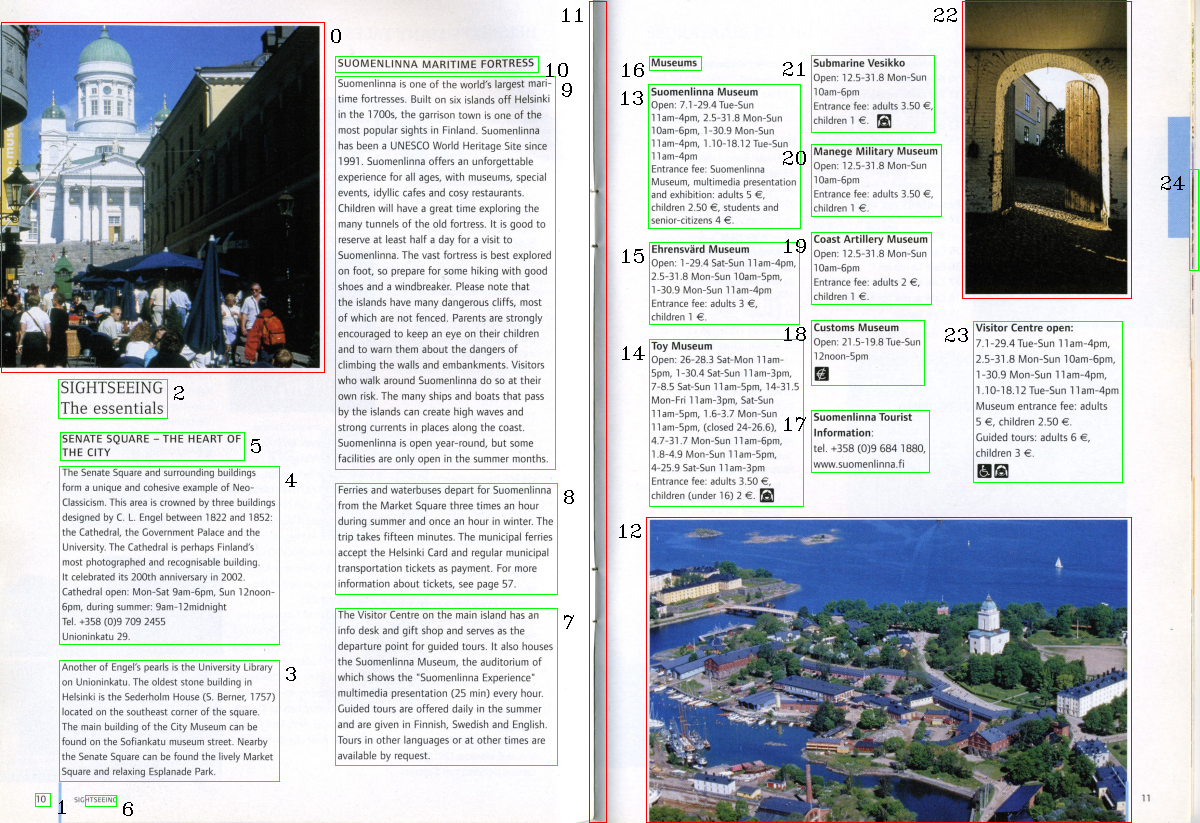

In [8]:
Image(filename="output/image_contours.png")

#### Mark false positives and erroneous or missing elements.

Check the image above for any false positives. Enter their numbers, separated by a space, below (e.g. 11 24 32).

In [9]:
fp_list = false_positives(raw_input())

11 24


Do you wish to mark additional elements in the document image (y/n)?

In [10]:
# Write a function that takes a raw input: 'y' opens a new window for marking the areas, 'n' continues.

#### Project the contours on the original high resolution document image.

In [11]:
hires_contours = project(image, original, classified_contours)

## 4. Generate the annotation.

Open the XML file for the layout layer annotation.

In [12]:
layout_file_name = 'output/' + str(filename) + '-layout-2.xml'
layout_xml = codecs.open(layout_file_name, 'w', 'utf-8')

layout_xml_opening = '<?xml version="1.0" encoding="UTF-8"?>\n\n <gemLayout>\n'

Open the XML file for the base layer annotation.

In [13]:
base_file_name = 'output/' + str(filename) + '-base-2.xml'
base_xml = codecs.open(base_file_name, 'w', 'utf-8')

base_xml_opening = '<?xml version="1.0" encoding="UTF-8"?>\n\n <gemBase>\n'

Begin the generating the annotation.

In [14]:
layout_xml.write(layout_xml_opening)
base_xml.write(base_xml_opening)

In [15]:
# Set up lists and dictionaries for the annotation

# Base layer
base_units = []
base_layout_mapping = {}

# Layout layer
segmentation = []
area_model = []
realization = []

# Loop over the regions of interest
for num, hc in enumerate(hires_contours):
    # Check if the region of interest is flagged as a false positive
    if num in fp_list:
        continue
    else:
        # Define the region of interest in the high resolution image
        (x, y, w, h) = cv2.boundingRect(hc)
        bounding_box = original[y:y+h, x:x+w]
        
        # Check the classification
        if contour_types[num] == 'text':
            
            # Extract base units
            layout_unit_id, b_units = extract_bu(original, x, w, y, h, num)
            
            # Loop over the base units
            for base_unit in b_units:
                # Add base units to the list
                base_units.append(base_unit)
                # Assign identifier to each base unit
                base_id = 'u-1.' + str(len(base_units))
                # Map the base units to their layout unit
                base_layout_mapping[base_id] = layout_unit_id
                # Generate XML annotation
                unit = '\t<unit id="' + base_id + '">' + base_unit.replace('\n', ' ').rstrip() + '</unit>\n'
                # Write the XML into the base layer file
                base_xml.write("".join(unit))
            
            # Generate XML entries for the layout layer
            lu, sa, re = generate_text(original, x, w, y, h, num, base_layout_mapping)
            # Append the XML entries to the corresponding lists
            segmentation.append(lu)
            area_model.append(sa)
            realization.append(re)
            
        if contour_types[num] == 'photo':
            
            # Set up a placeholder for manual description
            base_units.append(str('Photo'))
            # Assign an identifier to the base unit
            vbase_id = 'u-1.' + str(len(base_units))
            # Map the base unit to the layout unit
            base_layout_mapping[vbase_id] = num
            # Generate XML annotation
            vunit = '\t<unit id="' + vbase_id + '" alt="Photo"/>\n'
            # Write the XML into the base layer file
            base_xml.write("".join(vunit))

            # Generate XML entries for the layout layer
            vlu, vsa, vre = generate_photo(original, x, w, y, h, num, base_layout_mapping)
            
            # Append descriptions to list
            segmentation.append(vlu)
            area_model.append(vsa)
            realization.append(vre)

## 4. Generate the GeM XML file

Generate annotation for layout layer segmentation.

In [16]:
segmentation_opening = '\t<segmentation>\n'

layout_xml.write("".join(segmentation_opening))

for s in segmentation:
    layout_xml.write("".join(s))
    
segmentation_closing = '\t</segmentation>\n'

layout_xml.write("".join(segmentation_closing))

Generate annotation for area model.

In [17]:
areamodel_opening = '\t<area-model>\n'

layout_xml.write("".join(areamodel_opening))

for a in area_model:
    layout_xml.write("".join(a))
    
areamodel_closing = '\t</area-model>\n'

layout_xml.write("".join(areamodel_closing))

Generate annotation for realization information.

In [18]:
realization_opening = '\t<realization>\n'

layout_xml.write("".join(realization_opening))

for r in realization:
    layout_xml.write("".join(r))
    
realization_closing = '\t</realization>\n'

layout_xml.write("".join(realization_closing))

Write the closing tags.

In [19]:
layout_xml_closing = '</gemLayout>'
base_xml_closing = '</gemBase>'

layout_xml.write("".join(layout_xml_closing))
base_xml.write("".join(base_xml_closing))

In [20]:
layout_xml.close()
base_xml.close()